
<h1><center>Identifying and Describing Sensor Signals,  Application of Basic Statistics and Feature Extraction Methods</center></h1>


# Introduction

In this tutorial, we will analyze sensor data which is collected from a market shelf. The sensors deployed on the shelf collect data from pick-up and drop item actions. For instance, the data consists of cookies, eggs, detergent being picked up or being dropped to a shelf by a customer. If we can detect the type of action, this could be the foundations of building a system like [Amazon Go](#amazon-go) without actually using computationally expensive methods.

The data we will be using is already labeled with several types of items and their corresponding actions.

The sensor data is collected by geophones which measure the vibration occuring from the actions of the customers.

<b>We will analyze the sensor data and compute some basic statistics to be fed to our classifier as input. By analyzing such data we will also be learning what could be one of the possible approaches to extract features when we are given a sensor data in the future.</b>

Since the data only consists of vibration signals, it is hard to differentiate which item is being picked or dropped, rather we will be focusing on determining the action itself (item picked or dropped).

One thing worth mentioning before we start; although our data is collected from a set of sensors, one reading is not a successive, or a predecessor of another reading, which allows us to aggregate the data without the need of capturing any trends, unlike other time-series analysis such as stock prediction where a unified data follows a specific pattern over time.
****

# Tutorial content

In this tutorial, we will show how to do some basic statistical analysis in python by using pandas, matplotlib, numpy and sklearn.
The data we will be using has been collected from CMU-SV campus by sensors attached to an arduino and it's available for project use.

The topics will be covered are as follows;

- [Installing the libraries](#Installing-the-libraries)
- [Loading Data](#Loading-Data)
- [Plotting Data](#Plotting-Data)
- [Creating Dataframes and Computing Basic Statistics](#Creating-dataframes)
- [Identification/ Building the Classifier](#Building-Classifier)
- [Evaluating the results](#Evaluating-Results)
- [Notes](#Notes)
- [References](#References)
****

<a id='Installing-the-libraries'></a>
# Installing the Libraries/ Dependencies

- `$ pip install -U scikit-learn`
- `$ pip install pandas`
- `$ pip install numpy`

<a id='Loading-Data'></a>
# Loading Data

It's time to load the data which is provided in csv format separated by new lines.<br>

The data has been collected at a frequency of `10,000` samples a second. Although the data only consists of the magnitude of the signal, we can easily generate the corresponding timestamps with the fact that we know it's sampling rate, the finalized dataframe will consist of
columns <b>`timestamp`</b> and <b>`magnitude`</b> respectively.

| timestamp | magnitude   |
|------|------|
|   3.7754  | 0.008498|

The data consists of two different classes of actions;
<b>pick-up</b> and <b>drop</b>


The sample data can be found here: https://drive.google.com/drive/folders/145VV9-ygckhJQJqfY17JUp_LmWpR3xxi?usp=sharing<br>

First, we will need to load both drop and pick actions for items which are in different directories under <mark>data</mark> folder.

The following code makes it possible to load every file with csv extension under a directory, for instance: data_wood_shelf_cookies_pickup/.../.csv or data_wood_butter_drop/.../.csv. This way, we will put all the related csv files into two arrays of drop and pick-up actions. The fact that we load load them in different arrays will come in handy later in the tutorial for classification purposes.


In [2]:
import pandas as pd
import glob, os  
import numpy as np

path = '../data'
drop_Files = glob.glob(path + "/*_shelf_wood_drop*.csv")
pick_Files = glob.glob(path + "/*_shelf_wood_pick*.csv")

drop = []
pick = []

for file_ in drop_Files:
    df = pd.read_csv(file_,index_col=None, header=None).iloc[1:]
    df['timestamp'] = np.linspace(0.0, len(df) / 10000.0 * len(df), num=len(df))
    #reorder the columns
    columns = df.columns.tolist()
    columns = columns[-1:] + columns[:-1]
    df = df[columns] 
    df.rename(columns={df.columns[1]: "magnitude"}, inplace=True)
    df['magnitude'] = df['magnitude'].astype(int)
    drop.append(df)
    
for file_ in pick_Files:
    df = pd.read_csv(file_,index_col=None, header=None).iloc[1:] 
    df['timestamp'] = np.linspace(0.0, len(df) / 10000.0 * len(df), num=len(df))
    columns = df.columns.tolist()
    columns = columns[-1:] + columns[:-1]
    df = df[columns]
    df.rename(columns={df.columns[1]: "magnitude"}, inplace=True)
    df['magnitude'] = df['magnitude'].astype(int)
    pick.append(df)



Now that we have the csv data loaded into our list of dataframes, we can start data processing!

The following line just checks whether we have the same length of data from all the classes. This step is not really a must, but we just want to make sure that it loads without any problems and that everything is fine by now.

In [3]:
print('Drop Count: {:.2f}'.format(len(drop)), 'Pick Count: {:.2f}'.format(len(pick)))
assert len(pick) == len(drop), "sizes dont match"

Drop Count: 203.00 Pick Count: 203.00


 <a id='Plotting-Data'></a>
# Plotting Data 

Now that we load our data, let's take 2 samples from each class; pick-up and drop, respectively and plot them to see how our sensor data looks like. Even by looking at the plots generated by the 2 samples, we can easily observe that the two actions look pretty different from each other, moreover, it is generally the case for the whole dataset in hand.


_By this point, we should be excited that actually we have a high chance of being successful in transferring the burden of signal identification from humans to robots!!_

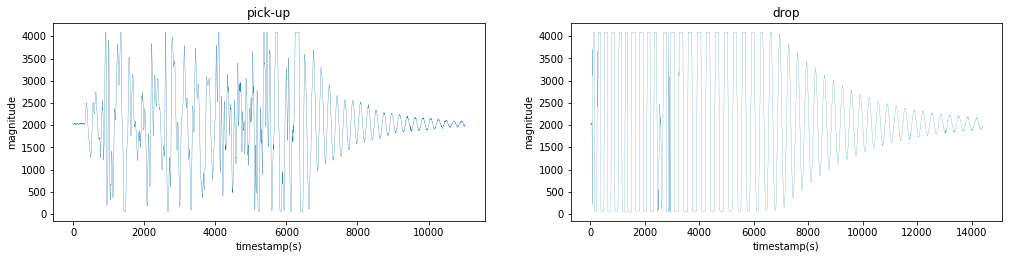

In [6]:
from matplotlib import pyplot as plt

fig = plt.gcf()
fig.set_size_inches(17, 8)

pick_plot = pick[0]


ax1 = plt.subplot(2, 2, 3)
plt.plot(pick_plot['timestamp'], pick_plot['magnitude'], linewidth=0.3)
plt.ylabel('magnitude')
plt.xlabel('timestamp(s)')
plt.title('pick-up')


drop_plot = drop[4] 

plt.subplot(2, 2, 4)
plt.plot(drop_plot['timestamp'], drop_plot['magnitude'], linewidth=0.2)
plt.xlabel('timestamp(s)')
plt.ylabel('magnitude')
plt.title('drop')

plt.show()


<a id ="Creating-dataframes"> </a>
# Creating Dataframes and Computing Basic Statistics

Now it's time for data wrangling and computing statistics! <br>

It turns out <b>summary statistics</b> can be one of the key points in sensor data analysis. 
They are the ingredients (possible features) to our classification model to help us classify whether it's a pickup or drop action.

We will be computing statistics such as <b>mean</b>, <b>standard deviation</b>, <b>root mean square</b> etc. for each reading.

While computing the statistics, we will also want to create a label column, namely picked which will be a binary value indicating whether the item is picked or not.

You can read more about `describe()` function in the documentation:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html


In [9]:
df_picked = pd.DataFrame()
df_dropped = pd.DataFrame()

merged_actions = {"dropped" : drop, "picked": pick}
df_dict = {"picked" : df_picked, "dropped": df_dropped}

for key, action in merged_actions.items():
    for each in action:
        statistics = each['magnitude'].describe()
        rms = np.sqrt(np.mean(each['magnitude'] **2))
        picked = 1 if key == 'picked' else 0
        dropped = 1 if key == 'dropped' else 0
        df_dict[key] = df_dict[key].append({'mean': statistics['mean'],
                    'std': statistics['std'], 
                    'rms': rms,
                    'minimum':  statistics['min'],
                    'percentile_25' : statistics['25%'], 
                    'percentile_50' : statistics['50%'],
                    'percentile_75' : statistics['75%'],
                    'max' : statistics['max'],
                    'cov': 1.0 * np.mean(each['magnitude']) / statistics['std'],              
                    'kurtosis' : each['magnitude'].kurt(),  # Kurtosis is the fourth central moment divided by the square of the variance. 
                    'skewness' : each['magnitude'].skew(),
                    'variance' : each['magnitude'].var(),             
                    'picked': picked
                    }, ignore_index=True)

In [10]:
"""
We can now merge the two dataframes to obtain the final data which consists both pickup and drop statistics
"""
labeled_df = df_dict['picked'].append(df_dict['dropped'])

In [11]:
"""
Here's how our shuffled and index dropped dataframe looks like
"""
labeled_df = labeled_df.sample(frac=1).reset_index(drop=True)
labeled_df.head(5)

,cov,kurtosis,max,mean,minimum,percentile_25,percentile_50,percentile_75,picked,rms,skewness,std,variance
0,1.374235,-1.326846,4094.0,2041.999852,48.0,494.0,2023.0,3516.50,0.0,2525.381481,0.041423,1485.917825,2.207952e+06
1,3.072564,1.825553,4094.0,2029.680167,58.0,1754.0,2026.5,2300.00,1.0,2134.463329,0.114227,660.581933,4.363685e+05
2,1.879550,-0.401743,4094.0,2032.367857,48.0,1381.0,2053.5,2661.25,1.0,2302.098339,0.034632,1081.305309,1.169221e+06
3,1.397899,-1.317884,4094.0,2049.277378,48.0,641.0,2025.0,3354.00,0.0,2519.624855,0.023695,1465.969697,2.149067e+06
4,1.233670,-1.634508,4094.0,2050.558963,47.0,58.0,2016.0,4093.00,0.0,2639.577051,0.037874,1662.161122,2.762780e+06


<a id='Building-Classifier'></a>
# Identification/ Building the Classifier
Now that we extracted our <b>statistical features</b>, it is time for us to build our classifier.<br>
For this purpose, we will use <b>Logistic Regression</b> to differentiate between a pickup and a drop event.

For the training input `X`, we will drop the actual class labels to be given in `y` as the desired output.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = labeled_df.drop(['picked'], axis=1).values
y = labeled_df[['picked']].values

y = np.ravel(y) #reducing the matrix into one dimensional vector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

lr = LogisticRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

<a id='Evaluating-Results'></a>
# Evaluating Results

- Let's evaluate our model and see how well we did in classifying the actions.
`lr.score()` will give us the ratio of: <br></br> `correct predictions / total number of data points`. However, it is not enough to judge the model by itself.

- We will also compute <b>F-measure</b> and <b>AUC</b> (area under the roc curve) in order to evaluate the robustness of our logistic regression model.

F1-score or F-measure, is calculated as follows: `2 * ((precision * recall)/(precision + recall))`
<br></br>
where Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).
<br></br>
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).
<br></br>
(ref: [1](#References))
<br></br> You can read more about F-measure: https://en.wikipedia.org/wiki/F1_score
- ROC curve which stands for Receiver Operating Characteristics is a very common evalution method for binary classifiers. We will predict the probability estimates of our model to build the ROC curve. The <span style="color:red"> dotted line</span> in the middle shows how good could we do if we used a random classifier. Our model result which is shown by the <span style="color:blue"> blue curve</span> certainly performs better.

<br></br> You can read more about ROC: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- Note: We could also compute confusion matrix to get an understanding of total correct and incorrect predictions that our model generated. But here in this tutorial we will just skip that evaluation metric. You can read more about it here http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

One of the advantages of using logistic regression is that it's transparent and straightforward. We can easily keep track of what's going on and how does it make predictions. Let's take a deeper look at our model, more specifically let's look at what our <b>feature weights/coefficients</b> are. This way, we can get an understanding of which feature is effective and which one doesn't play any crucial role in the model. For the future work, we can take these coeffients into consideration in feature selection, but for now let's leave it like this.


In [20]:
coefficients = lr.coef_
intercept = lr.intercept_

print(coefficients[0])
print(intercept)

[ -6.62661811e-06  -2.02415038e-05   2.02724602e-03  -1.22428956e-04
  -1.45905369e-04  -2.50373810e-03  -1.39064198e-04   1.47051743e-03
   3.04419439e-05   8.41926544e-07   7.74715856e-04  -6.20637434e-06]
[  2.47598463e-07]


So far, we have been doing things with libraries, but here's the interesting part; We can actually check manually if a random data point is whether a pick-up or a drop action by using it's features and our model's weights. Following formulas help us achieve that:<br> </br>


\begin{equation*}
p = intercept + weights ∗ features \\
inverseLogit   = e^p  /  (1 + e^p)
\end{equation*}

You can read more about logit function here: https://en.wikipedia.org/wiki/Logit <br> </br>
if the value that we calculate with the inverse logit funtion is above 0.5 which is the default threshold value in sklearn, then it is a pick-up action. <br> </br>

Let's assume we are given this data point which we already know it's a pick-up but nevertheless we would like to predict it's class manually by using the coefficients and the features.
Let's take the second row of our dataframe as a test input.

In [14]:
labeled_df.loc[[1]]

,cov,kurtosis,max,mean,minimum,percentile_25,percentile_50,percentile_75,picked,rms,skewness,std,variance
1,3.072564,1.825553,4094.0,2029.680167,58.0,1754.0,2026.5,2300.0,1.0,2134.463329,0.114227,660.581933,436368.489581


We will plug in all the features with their corresponding weights as follows to calculate p in our equation;

`sum = 2.47598463e-07 + -6.34836688e-06 * 3.072564 + -2.02415038e-05 * 1.825553 .....`

In [21]:
multiplication = coefficients[0] * labeled_df.loc[[1]].drop('picked', axis=1)
sum = multiplication.iloc[:,0:multiplication.size].sum(axis=1)

After calculating the sum of all the features multiplied by their coefficients, all we have to do is to plug in the values into our inverse logit equation and get our prediction as the output.

In [22]:
import math

p = intercept + sum
inv_logit = math.exp(p) /  (1 + math.exp(p))

print("Our Prediction: " + str(inv_logit))

Our Prediction: 0.9902416753276451


As we can see from the prediction value, there is a high chance that this particular row is a pick-up action..<br> </br>
Now let's continue <b>evaluating</b> our model by using sklearn's default evaluation functions.

In [17]:
# Accuracy 
print('Accuracy on test set: {:.2f}'.format(lr.score(X_test, y_test)))
print('Accuracy on training set: {:.2f}'.format(lr.score(X_train, y_train)))

Accuracy on test set: 0.81
Accuracy on training set: 0.84


In [23]:
# F-Measure
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.79      0.89      0.84        90
        1.0       0.84      0.71      0.77        73

avg / total       0.81      0.81      0.81       163



AUC: 0.80


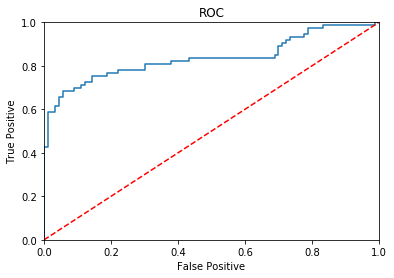

In [29]:
#AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_test, lr.predict(X_test))

false_positive, true_positive, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

print('AUC: {:.2f}'.format(auc))

plt.figure()
plt.plot(false_positive, true_positive)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])


plt.plot([0, 1], [0, 1],'r--')


plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

<a id='Notes'></a>
# Notes
By looking at the evaluation results, It seems like nothing can stop us now if we are given this type of task in the future. We can even get better results by extracting more features by using libraries like https://github.com/blue-yonder/tsfresh or select the most relevant features by using methods like _Correlation-based Feature Selection_.

<a id='References'></a>
# References
Amazon Go: https://www.amazon.com/b?ie=UTF8&node=16008589011
<br></br>
1: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html